In [3]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [4]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop10_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop10_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop10_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193, 264, 264), (1193, 264, 264), (1193, 264, 264), (1193,), (1193,), (1193,)]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

class AE(nn.Module):
    def __init__(self, ld, rank):
        super(AE, self).__init__()
        self.rank = rank
        self.enc1 = nn.Linear(34716, ld).float().cuda()
        self.dec1 = nn.Linear(ld, rank*264).float().cuda()

    def enc(self, x):
        return self.enc1(x)

    def dec(self, x):
        y = self.dec1(x)
        y = y.reshape(x.shape[0], 264, self.rank)
        y = torch.einsum('nab,ncb->nac', y, y)
        return y

    def decvec(self, x):
        y = self.dec(x)
        a,b = np.triu_indices(264,1)
        y = y[:,a,b]
        return y

# ae = AE(2000, 10)
# ae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat1000_rank5_ae.torch'))
# ae.eval()

# print(ae.rank)
# print(ae.enc1.weight.shape)
        
x = np.concatenate([rest, nback, emoid])
x = torch.from_numpy(x).float().cuda()

ae = AE(2000, 10)
optim = torch.optim.Adam(ae.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 1000
pperiod = 20
bsize = 300

for e in range(nepochs):
    for b in range(0,len(x),bsize):
        optim.zero_grad()
        bx = x[b:b+bsize]
        by = ae.enc(bx)
        by = ae.decvec(by)
        loss = rmse(bx, by)
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)}')

print('Done')

0 0.3887786269187927
0 1.9827572107315063
0 0.46827924251556396
0 0.6845436692237854
0 0.7398352026939392
0 0.581357479095459
0 0.45616206526756287
0 0.3671603500843048
0 0.37324246764183044
0 0.2990613579750061
0 0.2947968542575836
0 0.2836749255657196
20 0.15729521214962006
20 0.1647568643093109
20 0.16216541826725006
20 0.15447919070720673
20 0.15282824635505676
20 0.1558500975370407
20 0.1491198092699051
20 0.15101714432239532
20 0.15843144059181213
20 0.16483928263187408
20 0.1453831046819687
20 0.1677674502134323
40 0.14249128103256226
40 0.1462625414133072
40 0.14563274383544922
40 0.1439601331949234
40 0.13781622052192688
40 0.13213641941547394
40 0.1279129832983017
40 0.1261555403470993
40 0.1328246295452118
40 0.1449698805809021
40 0.12966178357601166
40 0.13862311840057373
60 0.16175824403762817
60 0.1397441178560257
60 0.15189127624034882
60 0.15549583733081818
60 0.13285592198371887
60 0.14560268819332123
60 0.13808786869049072
60 0.1347648948431015
60 0.1481410413980484
6

In [8]:
# Save AE

torch.save(ae.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat2000_rank10_ae.torch')

print('Done')

Done


In [9]:
# Linear regularizers

from sklearn.linear_model import Ridge, LogisticRegression

age_reg = Ridge(alpha=100).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([age, age, age]))
age_w = torch.from_numpy(age_reg.coef_).float().cuda()
age_i = age_reg.intercept_

sex_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([sex, sex, sex]))
sex_w = torch.from_numpy(sex_reg.coef_[0]).float().cuda()
sex_i = sex_reg.intercept_[0]

race_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), np.concatenate([race, race, race]))
race_w = torch.from_numpy(race_reg.coef_[0]).float().cuda()
race_i = race_reg.intercept_[0]

rest_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), 
                                                        np.concatenate([np.ones(len(rest)), np.zeros(len(rest)*2)]))
rest_w = torch.from_numpy(rest_reg.coef_[0]).float().cuda()
rest_i = rest_reg.intercept_[0]

nback_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), 
                                                        np.concatenate([np.zeros(len(rest)), np.ones(len(rest)), np.zeros(len(rest))]))
nback_w = torch.from_numpy(nback_reg.coef_[0]).float().cuda()
nback_i = nback_reg.intercept_[0]

emoid_reg = LogisticRegression(C=100, max_iter=1000).fit(np.concatenate([rest, nback, emoid], axis=0), 
                                                        np.concatenate([np.zeros(len(rest)*2), np.ones(len(rest))]))
emoid_w = torch.from_numpy(emoid_reg.coef_[0]).float().cuda()
emoid_i = emoid_reg.intercept_[0]

print(age_i)
print(sex_i)
print(race_i)
print(rest_i)
print(nback_i)
print(emoid_i)

14.171276625960939
-5.628305026005052
13.770769923836573
-4.934013659913669
3.1447410311238118
-9.891351467875902


In [21]:
# WGAN

import random

class Gen(nn.Module):
    def __init__(self, ld, nd):
        super(Gen, self).__init__()
        self.nd = nd
        self.enc1 = nn.Linear(8+nd, 100).float().cuda()
        self.enc2 = nn.Linear(100, ld).float().cuda()

    def forward(self, n, ag, sx, rc, rst, nbk, emd):
        x = torch.normal(0, 1, size=(n, self.nd)).float().cuda()
        x = torch.cat([x, torch.ones(n, 1).float().cuda()*ag, 
                       torch.ones(n, 1).float().cuda()*sx, 
                       torch.ones(n, 1).float().cuda()*(1-sx),
                       torch.ones(n, 1).float().cuda()*rc, 
                       torch.ones(n, 1).float().cuda()*(1-rc),
                       torch.ones(n, 1).float().cuda()*rst,
                       torch.ones(n, 1).float().cuda()*nbk,
                       torch.ones(n, 1).float().cuda()*emd], dim=1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

ce = nn.CrossEntropyLoss()

def latToVec(ae, z):
    p = ae.decvec(z)
    return p

def clamp(disc, a):
    with torch.no_grad():
        disc.fc1.weight[disc.fc1.weight > a] = a
        disc.fc1.weight[disc.fc1.weight < -a] = -a
        disc.fc2.weight[disc.fc2.weight > a] = a
        disc.fc2.weight[disc.fc2.weight < -a] = -a

class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.fc1 = nn.Linear(34716, 50).float().cuda()
        self.fc2 = nn.Linear(50, 2).float().cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def rmse(a, b):
    return torch.mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

x = np.concatenate([rest, nback, emoid])
x = torch.from_numpy(x).float().cuda()

gen = Gen(2000, 20)
disc = Disc()

# gen.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat1000_gen_10+8.torch'))
# gen.eval()

optimGen = torch.optim.Adam(gen.parameters(), lr=1e-4, weight_decay=1e-4)
optimDisc = torch.optim.Adam(disc.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 50000
pperiod = 100
nb = 10

for e in range(nepochs):
    # Real samples
    # -----
    optimDisc.zero_grad()
    xb = x[np.random.permutation(len(x))[:nb]]
    fake = disc(xb)
    loss0 = ce(fake, torch.zeros(nb).long().cuda())
    loss0.backward()
    optimDisc.step()
    clamp(disc, 2e-2)
    # Fake samples for disc
    # -----
    ag = random.randint(8,20)
    sx = random.randint(0,1)
    rc = random.randint(0,1)
    mod = random.randint(0,2)
    rst = int(mod == 0)
    nbk = int(mod == 1)
    emd = int(mod == 2)
    optimDisc.zero_grad()
    with torch.no_grad():
        xb = latToVec(ae, gen(nb, ag, sx, rc, rst, nbk, emd))
    fake = disc(xb)
    loss1 = ce(fake, torch.ones(nb).long().cuda())
    loss1.backward()
    optimDisc.step()
    clamp(disc, 2e-2)
    # Fake Samples for gen
    # -----
    optimGen.zero_grad()
    xb = latToVec(ae, gen(nb, ag, sx, rc, rst, nbk, emd))
    fake = disc(xb)
    loss2 = 2*ce(fake, torch.zeros(nb).long().cuda())
    # Get age
    age_hat = xb@age_w+age_i
    age_loss = 0.2*rmse(age_hat, ag)
    sex_hat = xb@sex_w+sex_i
    sex_loss = 0.2*ce(torch.stack([1-sex_hat, sex_hat], dim=1), torch.ones(nb).long().cuda()*sx)
    race_hat = xb@race_w+race_i
    race_loss = 0.2*ce(torch.stack([1-race_hat, race_hat], dim=1), torch.ones(nb).long().cuda()*rc)
    rest_hat = xb@rest_w+rest_i
    rest_loss = 0.02*ce(torch.stack([1-rest_hat, rest_hat], dim=1), torch.ones(nb).long().cuda()*rst)
    nback_hat = xb@nback_w+nback_i
    nback_loss = 0.02*ce(torch.stack([1-nback_hat, nback_hat], dim=1), torch.ones(nb).long().cuda()*nbk)
    emoid_hat = xb@emoid_w+emoid_i
    emoid_loss = 0.02*ce(torch.stack([1-emoid_hat, emoid_hat], dim=1), torch.ones(nb).long().cuda()*emd)
    (loss2+age_loss+sex_loss+race_loss+rest_loss+nback_loss+emoid_loss).backward()
    optimGen.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss0)} {pretty(loss1)} {pretty(loss2)} {pretty(sex_loss)}' +
              f' {pretty(race_loss)} {pretty(rest_loss)} {pretty(nback_loss)} {pretty(emoid_loss)}')
        print(ag, age_hat)

print('Done')

0 0.5752 0.7553 1.2779 0.0 5.4635 0.0001 0.0605 0.4626
11 tensor([13.8959, 14.1495, 13.5945, 13.2105, 13.7285, 13.6016, 13.8099, 13.7304,
        13.6166, 13.1271], device='cuda:0', grad_fn=<AddBackward0>)
100 0.0053 0.0576 5.6171 1.027 0.0 0.1719 0.0517 0.0
14 tensor([15.3660, 15.3289, 15.1407, 15.3564, 15.0078, 15.2026, 15.0858, 15.3881,
        15.3243, 14.8583], device='cuda:0', grad_fn=<AddBackward0>)
200 0.003 0.2747 3.0108 0.8119 3.2619 0.1785 0.0674 0.0
11 tensor([14.5892, 14.7601, 14.4562, 14.6727, 14.4662, 14.4964, 14.6400, 14.6144,
        14.2542, 14.8897], device='cuda:0', grad_fn=<AddBackward0>)
300 0.0029 0.3252 2.601 0.0002 0.0 0.1944 0.0703 0.0
12 tensor([14.2985, 14.3369, 14.4057, 14.2897, 14.4937, 14.3005, 14.3896, 14.4562,
        14.4320, 14.3375], device='cuda:0', grad_fn=<AddBackward0>)
400 0.0 0.2303 3.0814 0.9607 3.2455 0.0 0.0608 0.4026
13 tensor([14.5930, 14.7195, 14.8159, 14.4145, 14.5579, 14.3388, 14.4851, 14.6243,
        14.3098, 14.5525], device='cuda:0'

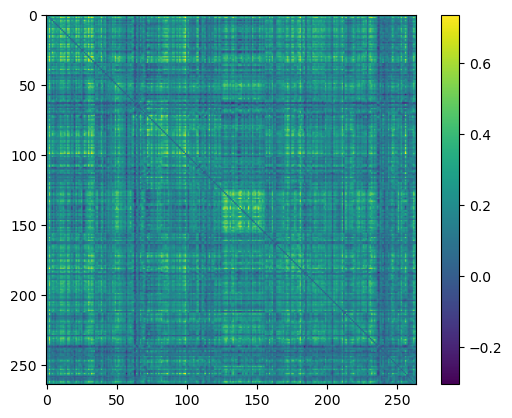

In [67]:
import matplotlib.pyplot as plt

with torch.no_grad():
    xb = latToVec(ae, gen(1, 22, 0, 0, 1, 0, 0))
    xb[xb > 1] = 1
    xb[xb < -1] = -1
    # mx = torch.max(xb)
    # if mx > 1:
    #     xb = xb / mx
    
plt.imshow(vec2mat(torch.mean(xb, dim=0).detach().cpu().numpy()))
# plt.imshow(restmat[4])
plt.colorbar()
plt.show()

In [68]:
# Save Generator and discriminator

torch.save(gen.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat2000_gen_20+8.torch')
torch.save(disc.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat50_lat2000_disc.torch')

print('Done')

Done


In [69]:
# Save weights

mygen = dict()

mygen['rank'] = 5
mygen['nd'] = 10
mygen['npheno'] = 8
mygen['latdim'] = 1000
mygen['enc_enc1_w'] = ae.enc1.weight.detach().cpu().numpy().T
mygen['enc_enc1_bias'] = ae.enc1.bias.detach().cpu().numpy()
mygen['enc_dec1_w'] = ae.dec1.weight.detach().cpu().numpy().T
mygen['enc_dec1_bias'] = ae.dec1.bias.detach().cpu().numpy()
mygen['gen_enc1_w'] = gen.enc1.weight.detach().cpu().numpy().T
mygen['gen_enc1_bias'] = gen.enc1.bias.detach().cpu().numpy()
mygen['gen_enc2_w'] = gen.enc2.weight.detach().cpu().numpy().T
mygen['gen_enc2_bias'] = gen.enc2.bias.detach().cpu().numpy()
mygen['disc_fc1_w'] = disc.fc1.weight.detach().cpu().numpy().T
mygen['disc_fc1_bias'] = disc.fc1.bias.detach().cpu().numpy()
mygen['disc_fc2_w'] = disc.fc2.weight.detach().cpu().numpy().T
mygen['disc_fc2_bias'] = disc.fc2.bias.detach().cpu().numpy()
mygen['age_w'] = age_w.detach().cpu().numpy()
mygen['age_i'] = age_i
mygen['sex_w'] = sex_w.detach().cpu().numpy()
mygen['sex_i'] = sex_i
mygen['race_w'] = race_w.detach().cpu().numpy()
mygen['race_i'] = race_i
mygen['rest_w'] = rest_w.detach().cpu().numpy()
mygen['rest_i'] = rest_i
mygen['nback_w'] = nback_w.detach().cpu().numpy()
mygen['nback_i'] = nback_i
mygen['emoid_w'] = emoid_w.detach().cpu().numpy()
mygen['emoid_i'] = emoid_i

import pickle

pickle.dump(mygen, open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/mygen3.pkl', 'wb'))

print('Done')

Done
